# RTM Example
We will perform RTM using the following steps:
1. Read the 10m resampled models output from the FWI notebook
    * true model
    * initial model
    * fwi model
2. Visualize the models 
3. Build a small local compute cluster (2 workers)
4. Create list of shot locations 
5. Build F, the distributed block operator for seismic modeling
6. Use F and generate "observed data" in the true model 
7. Apply simple direct arrival mute 
8. Use the Jacobian of F to migrate the observed data in each model
9. Perform a little post migration filtering
10. Visualize Results

#### Note on runtime
This notebook takes approximately 1 hour to run for 24 shots with two workers on an Intel 8168.

`lscpu` CPU information: `Intel(R) Xeon(R) Platinum 8168 CPU @ 2.70GHz`

## Add required packages

In [1]:
using Distributed, PyPlot, Jets, JetPack, JetPackDSP, Printf

## Record time for start of notebook

In [2]:
time_beg = time()

1.602889720974736e9

## 1. Read the models output from the FWI notebook

In [3]:
file1 = "../50_fwi/marmousi_resampled_10m_349x1701_vtrue.bin"
file2 = "../50_fwi/marmousi_resampled_10m_349x1701_vinit.bin"
filef = "../50_fwi/marmousi_resampled_10m_349x1701_vfwi.bin"

nz,nx = 349,1701
dz,dx = 10.0,10.0

v1_orig = read!(file1, Array{Float32}(undef,nz,nx));
v2_orig = read!(file2, Array{Float32}(undef,nz,nx));
vf_orig = read!(filef, Array{Float32}(undef,nz,nx));

####  Apply a 7x7 rectangular mix smoother
We perform the RTM migration in slightly smoothed models.

In [4]:
ns = 21
P = JopPad(JetSpace(Float32,nz,nx), -ns:nz+ns, -ns:nx+ns, extend=true)
M = JopMix(range(P), (7,7))
R = JopPad(JetSpace(Float32,nz,nx), -ns:nz+ns, -ns:nx+ns, extend=false)

s1 = R' ∘ M ∘ P * (1 ./ v1_orig)
s2 = R' ∘ M ∘ P * (1 ./ v2_orig)
sf = R' ∘ M ∘ P * (1 ./ vf_orig)

v1 = 1 ./(s1);
v2 = 1 ./(s2);
vf = 1 ./(sf);

## 2. Visualize the models

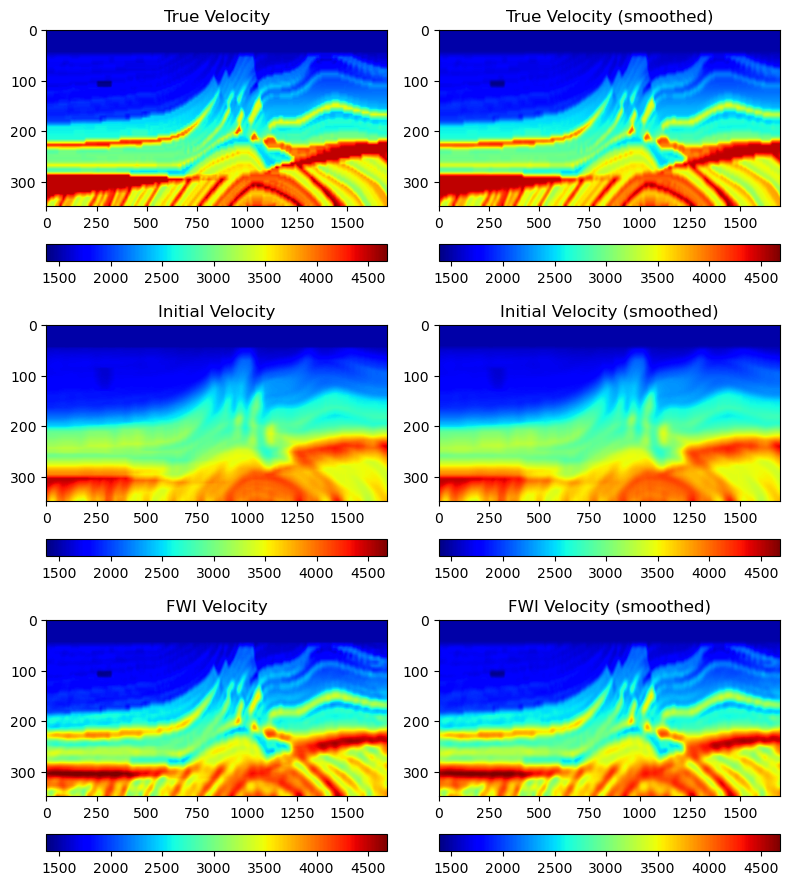

(vmin, vmax) = (1377.2083f0, 4688.674f0)


In [5]:
vmin,vmax = extrema(v1_orig)
@show vmin,vmax;

figure(figsize=(8,9)); clf()

subplot(3,2,1);imshow(v1_orig,aspect="auto",cmap="jet");
colorbar(orientation="horizontal");clim(vmin,vmax);
title("True Velocity")

subplot(3,2,2);imshow(v1,aspect="auto",cmap="jet");
colorbar(orientation="horizontal");clim(vmin,vmax);
title("True Velocity (smoothed)")


subplot(3,2,3);imshow(v2_orig,aspect="auto",cmap="jet");
colorbar(orientation="horizontal");clim(vmin,vmax);
title("Initial Velocity");

subplot(3,2,4);imshow(v2,aspect="auto",cmap="jet");
colorbar(orientation="horizontal");clim(vmin,vmax);
title("Initial Velocity (smoothed)");


subplot(3,2,5);imshow(vf_orig,aspect="auto",cmap="jet");
colorbar(orientation="horizontal");clim(vmin,vmax);
title("FWI Velocity");

subplot(3,2,6);imshow(vf,aspect="auto",cmap="jet");
colorbar(orientation="horizontal");clim(vmin,vmax);
title("FWI Velocity (smoothed)");

tight_layout()

## 3. Build a small local compute cluster (2 workers) 

#### Setup OMP environment variables for the cluster

In the distributed compute case the workers that we add would be on different hardware, and we might add tens of workers in 2D and hundreds in 3D. Here we run on a single machine with only 2 workers, and so we need to be careful with details related to high performance computing. If we did not specify thread affinity, the two workers would compete for the same physical cores and the modeling would be *incredibly* slow.

We spin up the small 2-worker cluster by calling `addprocs(2)`, and because we set the environment variable `ENV["OMP_DISPLAY_ENV"] = "true"` we will see the OMP environment printed out on each worker. In that output (below) we can verify that half of the total threads (44/2 = 22) are assigned to each socket on this 2 socket system. You can obtain more details about the hardware with the shell command `lscpu`.

We set four environment variables related to OpenMP:
* `OMP_DISPLAY_ENV` prints out the OpenMP environment on each worker
* `OMP_PROC_BIND` specifies that threads should be bound to physical cores
* `OMP_NUM_THREADS` specifies the number of threads per workers is 1/2 the number of physical cores
* `GOMP_CPU_AFFINITY` specifies which physical cores the threads run on for each worker

If you run the shell command `top` during execution, you will see 3 julia processes: the main process and two workers. The two workers should generally have about 50% of the system, and `load average` should tend towards the physical number of cores.

In [6]:
nthread = Sys.CPU_THREADS
ENV["OMP_DISPLAY_ENV"] = "true"
ENV["OMP_PROC_BIND"] = "close"
ENV["OMP_NUM_THREADS"] = "$(div(nthread,2))" 
addprocs(2)
@show workers()
for k in 1:nworkers()
    place1 = (k - 1) * div(nthread,nworkers())
    place2 = (k + 0) * div(nthread,nworkers()) - 1
    @show place1, place2, nthread
    @spawnat workers()[k] ENV["GOMP_CPU_AFFINITY"] = "$(place1)-$(place2)";
end

workers() = [2, 3]
(place1, place2, nthread) = (0, 21, 44)
(place1, place2, nthread) = (22, 43, 44)


In [7]:
@everywhere using DistributedArrays, DistributedJets, Jets, JetPack, WaveFD, JetPackWaveFD, Random, LinearAlgebra

      From worker 2:	
      From worker 2:	OPENMP DISPLAY ENVIRONMENT BEGIN
      From worker 2:	  _OPENMP = '201511'
      From worker 2:	  OMP_DYNAMIC = 'FALSE'
      From worker 2:	  OMP_NESTED = 'FALSE'
      From worker 2:	  OMP_NUM_THREADS = '22'
      From worker 2:	  OMP_SCHEDULE = 'DYNAMIC'
      From worker 2:	  OMP_PROC_BIND = 'CLOSE'
      From worker 2:	  OMP_PLACES = '{0},{1},{2},{3},{4},{5},{6},{7},{8},{9},{10},{11},{12},{13},{14},{15},{16},{17},{18},{19},{20},{21}'
      From worker 2:	  OMP_STACKSIZE = '0'
      From worker 2:	  OMP_WAIT_POLICY = 'PASSIVE'
      From worker 2:	  OMP_THREAD_LIMIT = '4294967295'
      From worker 2:	  OMP_MAX_ACTIVE_LEVELS = '2147483647'
      From worker 2:	  OMP_CANCELLATION = 'FALSE'
      From worker 2:	  OMP_DEFAULT_DEVICE = '0'
      From worker 2:	  OMP_MAX_TASK_PRIORITY = '0'
      From worker 2:	  OMP_DISPLAY_AFFINITY = 'FALSE'
      From worker 2:	  OMP_AFFINITY_FORMAT = 'level %L thread %i affinity %A'
      From worker 2:	OPE

## 4. Create list of shot locations 
We use 100 shot locations, many times than our FWI example, and run at significantly higher frequency. 

In [8]:
nshots = 100
sx = round.(Int,collect(range(0,stop=(nx-1)*dx,length=nshots)))
@show nshots;
@show sx;

nshots = 100
sx = [0, 172, 343, 515, 687, 859, 1030, 1202, 1374, 1545, 1717, 1889, 2061, 2232, 2404, 2576, 2747, 2919, 3091, 3263, 3434, 3606, 3778, 3949, 4121, 4293, 4465, 4636, 4808, 4980, 5152, 5323, 5495, 5667, 5838, 6010, 6182, 6354, 6525, 6697, 6869, 7040, 7212, 7384, 7556, 7727, 7899, 8071, 8242, 8414, 8586, 8758, 8929, 9101, 9273, 9444, 9616, 9788, 9960, 10131, 10303, 10475, 10646, 10818, 10990, 11162, 11333, 11505, 11677, 11848, 12020, 12192, 12364, 12535, 12707, 12879, 13051, 13222, 13394, 13566, 13737, 13909, 14081, 14253, 14424, 14596, 14768, 14939, 15111, 15283, 15455, 15626, 15798, 15970, 16141, 16313, 16485, 16657, 16828, 17000]


## 5. Build `F`, the distributed block operator for seismic modeling

#### Note on scratch space for temporary files
When dealing with serialized nonlinear wavefields as in this example, we need to specify the location where scratch files will be written.

You may need to change this to point to a temporary directory available on your system.

In [9]:
@everywhere scratch = "/mnt/scratch"
@assert isdir(scratch)

In [10]:
# notice we model to significantly shorter time than for FWI
@everywhere begin
    ntrec = 3001
    dtrec = 0.002
    dtmod = 0.001
end

@everywhere function makeF(i,nz,nx,dz,dx,sx)
    JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        nthreads = div(Sys.CPU_THREADS,2),
        ntrec = ntrec,
        dtrec = dtrec,
        dtmod = dtmod,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=10.0),
        sx = sx[i],
        sz = dz,
        rx = dx*[0:1:nx-1;],
        rz = 2*dz*ones(length(0:1:nx-1)),
        nbz_cache = nz,
        nbx_cache = 16,
        comptype = UInt32,
        srcfieldfile = joinpath(scratch, "field-$i-$(randstring()).bin"),
        reportinterval=12001)
end

In [11]:
F = @blockop DArray(I->[makeF(i,nz,nx,dz,dx,sx) for i in I[1], j in I[2]], (nshots,1))

"Jet nonlinear operator, (349, 1701) → (510470100,)"

## 6. Use `F` and generate "observed data" in the true model 

In [12]:
t1 = @elapsed begin
    d1 = F*v1
end
@show t1;

[ Info: nonlinear forward on cbox-HC44rs2, srcfieldfile=/mnt/scratch/field-1-RRuDHmWB.bin
[ Info: nonlinear forward on cbox-HC44rs2, srcfieldfile=/mnt/scratch/field-51-WNLVOkBQ.bin
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  6001 of  6001 ;  498.12 MCells/s (IO=29.27%, EX=50.35%) -- rms d,p; 1.4640e-01 1.3736e-02
[ Info: nonlinear forward on cbox-HC44rs2, srcfieldfile=/mnt/scratch/field-2-HG11DSFT.bin
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  6001 of  6001 ;  463.17 MCells/s (IO=31.31%, EX=48.37%) -- rms d,p; 2.0000e-01 1.3681e-02
[ Info: nonlinear forward on cbox-HC44rs2, srcfieldfile=/mnt/scratch/field-52-eKDYCAPB.bin
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  6001 of  6001 ;  495.11 MCells/s (IO=26.96%, EX=54.01%) -- rms d,p; 1.7263e-01 1.3416e-02
[ Info: nonlinear forward on cbox-HC44rs2, srcfieldfile=/mnt/scratch/field-3-6k64FiQf.bin
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  6001 of  6001 

t1 = 531.717287467


[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  6001 of  6001 ;  500.06 MCells/s (IO=27.04%, EX=54.16%) -- rms d,p; 1.4681e-01 1.2565e-02


In [13]:
@printf("Time for modeling %.2f minutes\n", t1 / 60)

Time for modeling 8.86 minutes


## 7. Apply simple direct arrival mute 
We apply a simple mute based on the Marmousi water velocity of 1500 m/s and the offset from the traces headers. 

#### Define two functions to implement the mute for distributed block arrays
* The 1st function dispatches on the remote worker that "owns" the block of data
* The 2nd function implements a simple step function mute. 

In [14]:
@everywhere function timemute!(F, d::DBArray, watervel, tmute)
    @sync for pid in procs(d)
        @async remotecall_fetch(timemute_local!, pid, F, d, watervel, tmute)
    end
end

@everywhere function timemute_local!(F, d::DBArray{T}, watervel, tmute) where {T}
    for iblock in localblockindices(d)
        dᵢ = getblock(d, iblock)
        Fᵢ = getblock(F, iblock, 1)
        nt = state(Fᵢ, :ntrec)
        for i = 1:length(state(Fᵢ, :rx)) 
            rx = state(Fᵢ, :rx)
            rz = state(Fᵢ, :rz)
            sx = state(Fᵢ, :sx)
            sz = state(Fᵢ, :sz)
            dist = sqrt((sx[1] - rx[i])^2 + (sz[1] - rz[i])^2)
            time = dist / watervel
            tbeg = 1
            tend = min(nt,round(Int, (time + tmute) / state(Fᵢ,:dtrec)))
            dᵢ[tbeg:tend,i] .= 0
        end
    end
    nothing
end

#### Apply the mute and visualize the results for 2 shot gathers 
The mute time chosen is six periods (at Ricker peak frequency) beyond water arrival. Six periods was empirically tested to remove the refraction energy and improve the reflection image. 

In [15]:
watervel = minimum(v1)
tmute = 6/20
@show watervel
@show tmute

# copy distributed block array
d1_mute = zeros(range(F));
d1_mute .= d1;

# apply mute
timemute!(F, d1_mute, watervel, tmute)

# get local copies of 1st shot gather to plot
shots = [1, div(nshots,2), nshots]
local_d1 = [getblock(d1,k) for k in shots];
local_d1_mute = [getblock(d1_mute,k) for k in shots];

watervel = 1405.7601f0
tmute = 0.3


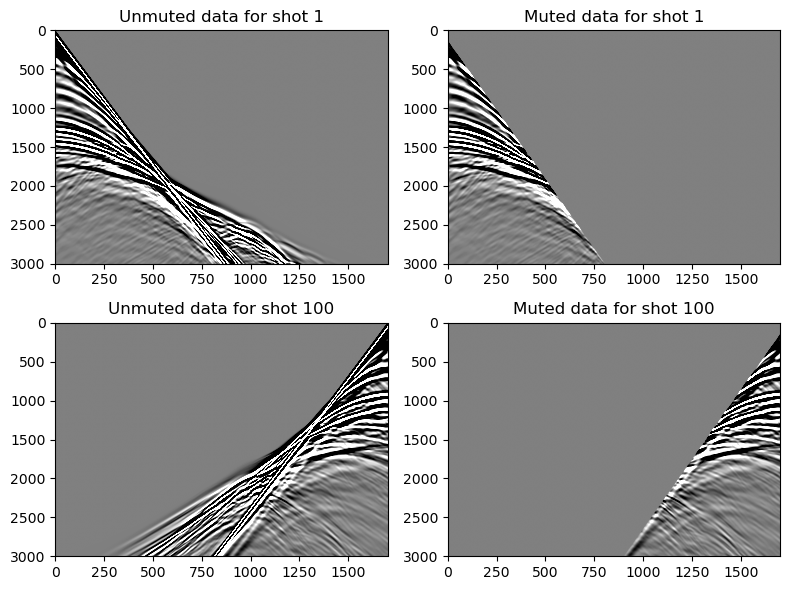

scale = 103.0545954435922


In [16]:
scale = 20.0 / sqrt(norm(d1)^2 / length(d1))
@show scale

figure(figsize=(8,6)); clf()

subplot(2,2,1);
imshow(scale .* local_d1[1],cmap="gray",aspect="auto",clim=[-1,+1]);
title("Unmuted data for shot 1");

subplot(2,2,2);
imshow(scale .* local_d1_mute[1],cmap="gray",aspect="auto",clim=[-1,+1]);
title("Muted data for shot 1");

subplot(2,2,3);
imshow(scale .* local_d1[end],cmap="gray",aspect="auto",clim=[-1,+1]);
title("Unmuted data for shot $(nshots)");

subplot(2,2,4);
imshow(scale .* local_d1_mute[end],cmap="gray",aspect="auto",clim=[-1,+1]);
title("Muted data for shot $(nshots)");

tight_layout();

## 8. Use the Jacobian of `F` to migrate the observed data in each model
Note there is no water bottom mute or preprocessing applied here at all, those would clearly be improvements to this brute force workflow.

#### Migrate in the true velocity model

In [17]:
t1 = @elapsed begin
    J1 = jacobian!(F, v1)
    illum1 = srcillum(J1)
    m1 = J1'*d1_mute;
end
@show extrema(m1)
@show extrema(illum1)

[ Info: linear adjoint on cbox-HC44rs2, srcfieldfile=/mnt/scratch/field-1-RRuDHmWB.bin
[ Info: PropLn2DAcoIsoDenQ_DEO2_FDTD, adjoint, time step     1 of  6001 ;    0.00 MCells/s (IO= 0.00%, EX= 0.00%, IM= 0.00%) -- rms d,p; 9.5501e-03 0.0000e+00
[ Info: linear adjoint on cbox-HC44rs2, srcfieldfile=/mnt/scratch/field-51-WNLVOkBQ.bin
[ Info: PropLn2DAcoIsoDenQ_DEO2_FDTD, adjoint, time step     1 of  6001 ;    0.00 MCells/s (IO= 0.00%, EX= 0.00%, IM= 0.00%) -- rms d,p; 8.9085e-03 0.0000e+00
[ Info: linear adjoint on cbox-HC44rs2, srcfieldfile=/mnt/scratch/field-2-HG11DSFT.bin
[ Info: PropLn2DAcoIsoDenQ_DEO2_FDTD, adjoint, time step     1 of  6001 ;    0.00 MCells/s (IO= 0.00%, EX= 0.00%, IM= 0.00%) -- rms d,p; 9.3366e-03 0.0000e+00
[ Info: linear adjoint on cbox-HC44rs2, srcfieldfile=/mnt/scratch/field-52-eKDYCAPB.bin
[ Info: PropLn2DAcoIsoDenQ_DEO2_FDTD, adjoint, time step     1 of  6001 ;    0.00 MCells/s (IO= 0.00%, EX= 0.00%, IM= 0.00%) -- rms d,p; 8.2322e-03 0.0000e+00
[ Info: linear

extrema(m1) = (-0.13616557f0, 0.074929945f0)
extrema(illum1) = (468.1538f0, 35202.133f0)


(468.1538f0, 35202.133f0)

In [18]:
@printf("Migrate time true model; %12.4f minutes\n", t1 / 60)

Migrate time true model;      10.0526 minutes


#### Migrate in the initial velocity model

In [19]:
t2 = @elapsed begin
    J2 = jacobian!(F, v2)
    illum2 = srcillum(J2)
    m2 = J2'*d1_mute;
end
@show extrema(m2)
@show extrema(illum2)

[ Info: nonlinear forward on cbox-HC44rs2, srcfieldfile=/mnt/scratch/field-1-RRuDHmWB.bin
[ Info: nonlinear forward on cbox-HC44rs2, srcfieldfile=/mnt/scratch/field-51-WNLVOkBQ.bin
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  6001 of  6001 ;  494.25 MCells/s (IO=25.57%, EX=58.05%) -- rms d,p; 0.0000e+00 1.3806e-02
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  6001 of  6001 ;  480.67 MCells/s (IO=24.46%, EX=59.15%) -- rms d,p; 0.0000e+00 1.2683e-02
[ Info: nonlinear forward on cbox-HC44rs2, srcfieldfile=/mnt/scratch/field-52-eKDYCAPB.bin
[ Info: nonlinear forward on cbox-HC44rs2, srcfieldfile=/mnt/scratch/field-2-HG11DSFT.bin
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  6001 of  6001 ;  513.16 MCells/s (IO=25.73%, EX=58.18%) -- rms d,p; 0.0000e+00 1.2639e-02
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  6001 of  6001 ;  491.51 MCells/s (IO=25.59%, EX=57.84%) -- rms d,p; 0.0000e+00 1.2206e-02
[ Info: nonlin

extrema(m2) = (-0.026092255f0, 0.023483751f0)
extrema(illum2) = (648.0937f0, 35208.95f0)


(648.0937f0, 35208.95f0)

In [20]:
@printf("Migrate time init model; %12.4f minutes\n", t2 / 60)

Migrate time init model;      18.4402 minutes


#### Migrate in the FWI velocity model

In [21]:
tf = @elapsed begin
    Jf = jacobian!(F, vf)
    illumf = srcillum(Jf)
    mf = Jf'*d1_mute;
end
@show extrema(mf)
@show extrema(illumf)

[ Info: nonlinear forward on cbox-HC44rs2, srcfieldfile=/mnt/scratch/field-1-RRuDHmWB.bin
[ Info: nonlinear forward on cbox-HC44rs2, srcfieldfile=/mnt/scratch/field-51-WNLVOkBQ.bin
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  6001 of  6001 ;  483.18 MCells/s (IO=25.81%, EX=58.67%) -- rms d,p; 0.0000e+00 1.3652e-02
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  6001 of  6001 ;  478.60 MCells/s (IO=26.48%, EX=57.20%) -- rms d,p; 0.0000e+00 1.3700e-02
[ Info: nonlinear forward on cbox-HC44rs2, srcfieldfile=/mnt/scratch/field-2-HG11DSFT.bin
[ Info: nonlinear forward on cbox-HC44rs2, srcfieldfile=/mnt/scratch/field-52-eKDYCAPB.bin
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  6001 of  6001 ;  486.57 MCells/s (IO=26.41%, EX=56.10%) -- rms d,p; 0.0000e+00 1.3484e-02
[ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  6001 of  6001 ;  481.21 MCells/s (IO=26.53%, EX=57.14%) -- rms d,p; 0.0000e+00 1.2186e-02
[ Info: nonlin

extrema(mf) = (-0.11775547f0, 0.0641327f0)
extrema(illumf) = (489.6249f0, 35202.203f0)


(489.6249f0, 35202.203f0)

In [22]:
@printf("Migrate time FWI  model; %12.4f minutes\n", tf / 60)

Migrate time FWI  model;      18.7208 minutes


## 9. Perform a little post migration filtering

#### Laplacian filter to remove low frequency backscattered noise

In [23]:
L = JopLaplacian(JetSpace(Float32,nz,nx))

"Jet linear operator, (349, 1701) → (349, 1701)"

#### Apply low cut filter, illumination compensation, and gain

In [24]:
g = ([0:(nz-1);]*dz).^2 * ones(1,nx);

img1 = g .* (L * m1) ./ (illum1 .+ 1e-8 * maximum(abs, illum1));
img2 = g .* (L * m2) ./ (illum2 .+ 1e-8 * maximum(abs, illum2));
imgf = g .* (L * mf) ./ (illumf .+ 1e-8 * maximum(abs, illumf));

@show extrema(img1)
@show extrema(img2)
@show extrema(imgf)

extrema(img1) = (-1.1057476941647673, 2.157935852686482)
extrema(img2) = (-1.4059873711728812, 1.2764796196692985)
extrema(imgf) = (-1.1440051367716604, 2.0930267334122674)


(-1.1440051367716604, 2.0930267334122674)

#### Apply water bottom mute

In [25]:
img1[v1.==1500.0] .= 0;
img2[v1.==1500.0] .= 0;
imgf[v1.==1500.0] .= 0;

## 10. Visualize Results

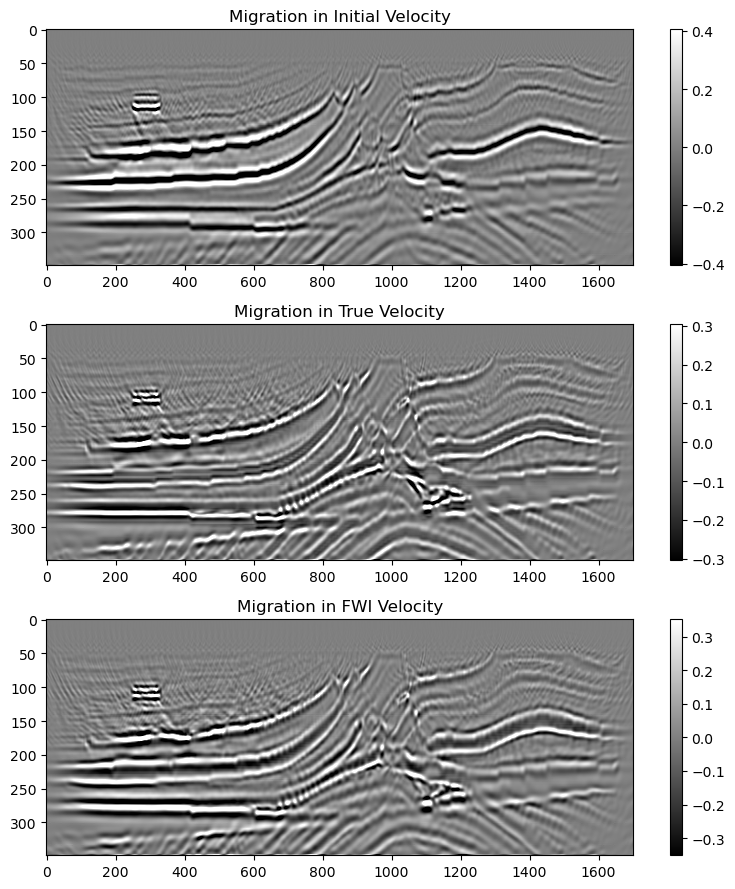

mrms1 = 0.30386726892453786
mrms2 = 0.4056791143309926
mrmsf = 0.35109729123013683


In [26]:
mrms1 = 2.5 * sqrt(norm(img1)^2 / length(img1))
mrms2 = 2.5 * sqrt(norm(img2)^2 / length(img2))
mrmsf = 2.5 * sqrt(norm(imgf)^2 / length(imgf))
@show mrms1
@show mrms2
@show mrmsf

figure(figsize=(8,9)); clf()

subplot(3,1,1);imshow(img2,aspect="auto",cmap="gray");
colorbar(orientation="vertical");clim(-mrms2,+mrms2);
title("Migration in Initial Velocity");

subplot(3,1,2);imshow(img1,aspect="auto",cmap="gray");
colorbar(orientation="vertical");clim(-mrms1,+mrms1);
title("Migration in True Velocity")

subplot(3,1,3);imshow(imgf,aspect="auto",cmap="gray");
colorbar(orientation="vertical");clim(-mrmsf,+mrmsf);
title("Migration in FWI Velocity");

tight_layout()

## Remove local files and workers

In [27]:
close(F);
rmprocs(workers());

## Record time at end of notebook
Report total elapsed time to run the notebook

In [28]:
time_end = time()
@sprintf("Time to run notebook; %.2f minutes\n", (time_end - time_beg) / 60)

"Time to run notebook; 56.87 minutes\n"